<a href="https://colab.research.google.com/github/Abdelrahman-Alkhodary/Computer-Vision_with_tensorflow/blob/main/CNN_TF_Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteTHY2DH/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpf8eexv_7tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*dataset_size))

  val_test_dataset  = dataset.skip(int(TRAIN_RATIO*dataset_size))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [24]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [25]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

# **Data Visualization**

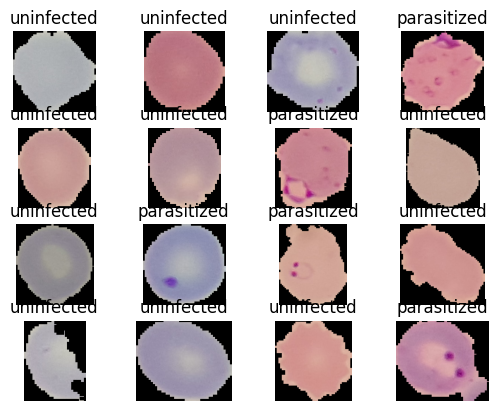

In [26]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [27]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(145, 148, 3)
(133, 127, 3)
(118, 118, 3)
(124, 121, 3)
(151, 148, 3)
(151, 130, 3)
(139, 175, 3)
(151, 139, 3)
(160, 148, 3)
(124, 130, 3)
(133, 136, 3)
(145, 163, 3)
(112, 115, 3)
(133, 133, 3)
(166, 184, 3)
(136, 130, 3)


In [28]:
# we will define a function to resize the image of the dataset as images have different sizes
# new image size will be square of 224
IM_SIZE = 224
def resizing_rescaling(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [29]:
train_dataset = train_dataset.map(resizing_rescaling)

In [32]:
val_dataset = val_dataset.map(resizing_rescaling)

test_dataset = test_dataset.map(resizing_rescaling)

In [13]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


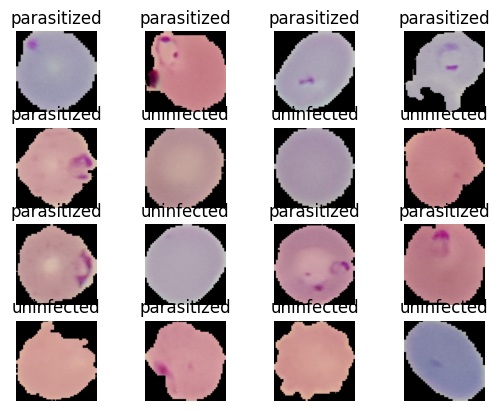

In [14]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [33]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
from keras.src.layers.serialization import activation
from keras.src.engine.training import input_ops
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [45]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics='accuracy'
)

In [46]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 45s 60ms/step - loss: 0.4293 - accuracy: 0.8067 - val_loss: 0.3685 - val_accuracy: 0.8824
Epoch 2/20
689/689 [==============================] - 41s 59ms/step - loss: 0.2326 - accuracy: 0.9279 - val_loss: 0.8117 - val_accuracy: 0.7877
Epoch 3/20
689/689 [==============================] - 49s 71ms/step - loss: 0.2178 - accuracy: 0.9301 - val_loss: 0.1963 - val_accuracy: 0.9343
Epoch 4/20
689/689 [==============================] - 49s 71ms/step - loss: 0.1949 - accuracy: 0.9360 - val_loss: 0.3160 - val_accuracy: 0.8762
Epoch 5/20
689/689 [==============================] - 41s 59ms/step - loss: 0.1834 - accuracy: 0.9396 - val_loss: 0.6735 - val_accuracy: 0.8508
Epoch 6/20
689/689 [==============================] - 65s 94ms/step - loss: 0.1684 - accuracy: 0.9462 - val_loss: 0.2046 - val_accuracy: 0.9426
Epoch 7/20
689/689 [==============================] - 53s 76ms/step - loss: 0.1607 - accuracy: 0.9470 - val_loss: 0.2320 - val_accuracy:

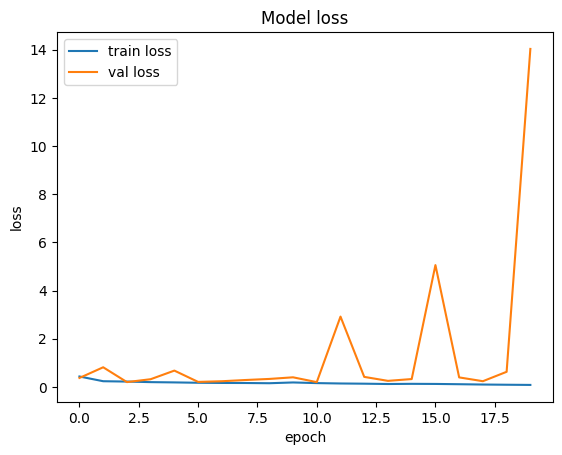

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

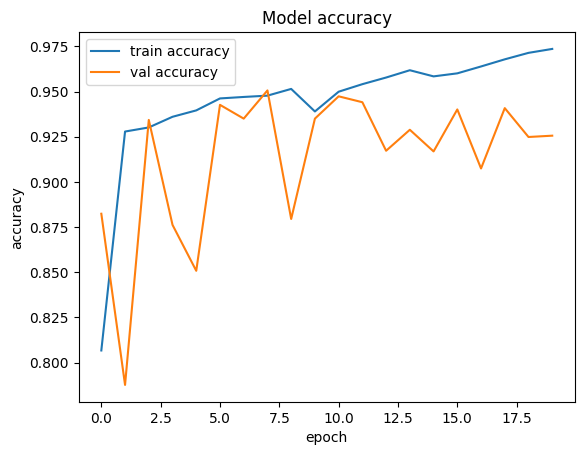

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [50]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [51]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 5.4655 - accuracy: 0.9249


[5.465506553649902, 0.9249184131622314]

In [61]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 12s 12s/step


array([[0.99732924]], dtype=float32)

In [56]:
def label_define(x):
  if x<0.5:
    return str('P')
  else:
    return str('U')

In [58]:
label_define(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 13s 13s/step


'U'

In [60]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.83170754

1/1 [==============================] - 0s 21ms/step


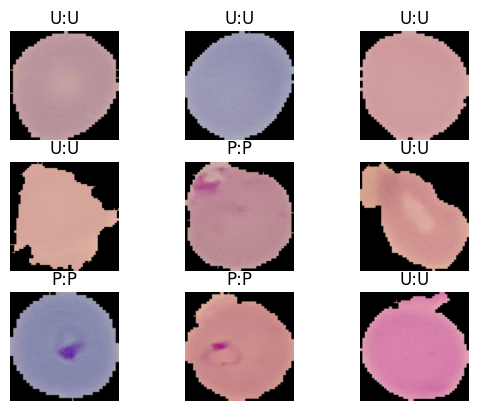

In [63]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(label_define(label.numpy()[0])) + ':' + str(label_define(model.predict(image)[0][0])))
  plt.axis('off')
  # plt.show()

In [64]:
# save the model configuration and the model's weights
model.save('LenetSavedModel')

In [65]:
lenet_loaded_model = tf.keras.models.load_model('LenetSavedModel')
lenet_loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [66]:
lenet_loaded_model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 5.4680 - accuracy: 0.9242


[5.468019485473633, 0.9241929650306702]

In [67]:
model.save('Lenet.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
lenet_loaded_model = tf.keras.models.load_model('Lenet.hdf5')
lenet_loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [69]:
# save only the model's weights
model.save_weights('weights/lenet_weights')

Saving to Google Drive

In [71]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [78]:
# copy the model to the drive
!cp -r /content/LenetSavedModel/ /content/drive/MyDrive/lenet/